Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: Is: command not found
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_70 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_71 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, 32)    

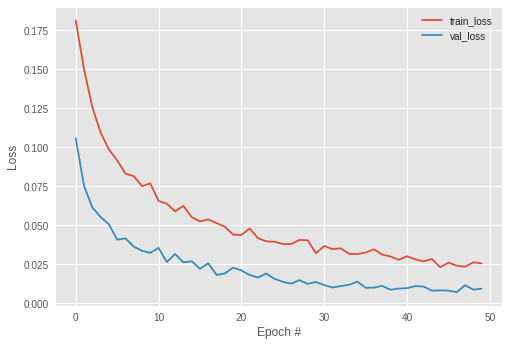

In [0]:
# this file is a *skeleton* for a triplet-loss network for embedding
# the MNIST digits.

# source: https://github.com/Ao-Lee/Shares/blob/master/triplet%20inputs.py
#
# adapted (a lot!) by James McDermott:
# - changed to MNIST task
# - changed to a small, simple network (not ResNet)
# - added generation of proper a, p, n triplets
# - increased alpha to try to prevent the embedding from winning trivially
# - removed the L2 normalisation (pushing all digits to surface of hypersphere)
# - added a 2D layout visualisation of our embedding
# (these comments apply to the full version, not the skeleton version provided here.)

from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from PIL import Image
from google.colab import drive
import tensorflow as tf
drive.mount('/content/drive')
!Is "/content/drive/My Drive/Colab Notebooks"
buf = "/content/drive/My Drive/Colab Notebooks/emnist_train_images_3.npy"

############## DATA ###########################
# load and shape data as usual, but here we don't process class labels
# to one-hot encoding. In fact, we don't exactly use class labels
# during training, only while setting up the triplets.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
def get_image(label, test=False):
    """Choose an image from our training or test data with the
    given label."""
    if test:
        y = y_test; X = X_test
    else:
        y = y_train; X = X_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        # keep searching randomly!
        idx = np.random.randint(len(y))
    return X[idx]
    
def get_triplet(test=False):
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    n = a = np.random.randint(10)
    while n == a:
        # keep searching randomly!
        n = np.random.randint(10)
    a, p = get_image(a, test), get_image(a, test)
    n = get_image(n, test)
    return a, p, n
  
def generate_triplets(test=False):
    """Generate an un-ending stream (ie a generator) of triplets for
    training or test."""
    while True:
        list_a = []
        list_p = []
        list_n = []
        for i in range(batch_size):
            a, p, n = get_triplet(test)
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)     
        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')
        # a "dummy" label which will come in to our identity loss
        # function below as y_true. We'll ignore it.
        label = np.ones(batch_size) 
        yield [A, P, N], label   

############## Loss ###########################
def identity_loss(y_true, y_pred):
    """This loss function just takes the mean of y_pred. Because of the
    way we wire the network (see complete_model below), y_pred is the
    output of the triplet loss, so minimising it is what we want to
    do."""
    return K.mean(y_pred)

def triplet_loss(x):
    """The triplet loss is ||A - P|| - ||A - N|| + alpha, where ||.||
    is the Euclidean norm. Notice that this is not a loss function in the
    format expected by Keras, ie f(y_true, y_pred)."""
    anchor, positive, negative = x
    # XXX YOUR CODE HERE: CALCULATE loss. USE K.
    p_dist = K.sqrt(K.sum(K.square(anchor-positive), axis=-1))
    n_dist = K.sqrt(K.sum(K.square(anchor-negative), axis=-1))
    loss =K.maximum(p_dist-n_dist+alpha,0)
    return loss
       
############## Model ###########################
def embedding_model():
    """A tiny model similar to the network we used for MNIST
    classification. We assume the architecture should be good for
    MNIST embedding. Its input is an image and output is an embedding,
    not a classification, so the final layer is not a softmax. We
    don't compile or add a loss since this will become a component in
    the complete model below."""
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), activation='relu',input_shape=(28,28,1)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32))
    return model

def complete_model(base_model):
    """This part of the model is quite tricky. Rather than a Sequential
    model, we declare a Model and say which are its inputs and
    outputs, and we declare how the outputs are calculated from the
    inputs. In particular, there are no layers in this model, *other
    than* the layers in the embedding model discussed above.

    A further complication is that our triplet loss can't be
    calculated as a function of y_true and y_predicted as
    usual. Instead we calculate the triplet loss as an extra Lambda
    layer. Then the Model's loss is set to be equal to the triplet
    loss via the identity function."""
    input_1 = Input((imsize, imsize, 1))
    input_2 = Input((imsize, imsize, 1))
    input_3 = Input((imsize, imsize, 1))
    # call the base_model three times to get A, P, N
    A=base_model(input_1)
    P=base_model(input_2)
    N=base_model(input_3)
    # XXX YOUR CODE HERE.
    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3],outputs=loss)
    model.compile(loss=identity_loss, optimizer=Adam(LR))
    return model

############## Settings ##########################
imsize = 28
# XXX you might like to play with some of these hyperparameters
batch_size = 100
# 2D is interesting for visualisation, but higher allows more "space"
# to achieve accuracy in complex domains, eg 128 is common for
# faces. but MNIST is simple, so maybe 2 is enough for us anyway.
embedding_dim = 2 
LR = 0.0001 # be careful: too large will be unstable for our data
EPOCHS = 50
alpha = 0.2 # interesting to think about different values
############## Main ###############################
# create the data generators
train_generator = generate_triplets()
test_generator = generate_triplets(test=True)
# instantiate the model and take a look
# XXX YOUR CODE HERE: create the embedding model and then use
base_model=embedding_model()
model=complete_model(base_model)
# that to create the complete model
print(model.summary())
# fit
# XXX YOUR CODE HERE: call fit_generator() to fit the model.
H =model.fit_generator(train_generator,validation_data=test_generator,epochs=EPOCHS,steps_per_epoch=30,validation_steps=20)

####################plot loss value##################################
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history['loss'], label="train_loss")
plt.plot(N, H.history['val_loss'], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("keras_mnist.png")
################# Visualisation ###################
# we add an extra 28 pixels to allow for images whose bottom-left is
# at the top or right border
canvas_size = 4000
canvas = np.zeros((canvas_size+imsize, canvas_size+imsize), dtype=float)
def loc2pix(x, size):
    """All values in x are in [-1, 1], we want it in [0, size]."""
    # add 1 to make it non-negative, squeeze to remove trivial
    # dimension and transform.
    x = (((1.0 + x.squeeze()) / 2) * size).astype(int)
    assert np.all(x >= 0) and np.all(x < size)
    return x
for ib, batch in enumerate(test_generator):
    APN, label = batch
    for i in range(batch_size):
        # get the embedding for a, p, n: each should be in [-1, 1]^2
        # XXX YOUR CODE HERE. Set a to be the embedding of APN[0][i:i+1],
        # and similarly p for APN[1][i:i+1] and n for APN[2][i:i+1].
        # Think about what you need to call.
        a=APN[0][i:i+1]
        p=APN[1][i:i+1]
        n=APN[2][i:i+1] 
        #A=model.predict([a,n,p])
        #print(A)
        a=base_model.predict(a)
        p=base_model.predict(p)
        n=base_model.predict(n)
       
        # transform a, p, n to pixel-space [0, 4028]^2
        a = loc2pix(a, canvas_size)
        p = loc2pix(p, canvas_size)
        n = loc2pix(n, canvas_size)
        # paint the image of each digit onto the canvas
        canvas[a[0]:a[0]+imsize, a[1]:a[1]+imsize] = APN[0][i].squeeze()
        canvas[p[0]:p[0]+imsize, p[1]:p[1]+imsize] = APN[1][i].squeeze()
        canvas[n[0]:n[0]+imsize, n[1]:n[1]+imsize] = APN[2][i].squeeze()        
    break # one batch of 100 samples is enough for visualisation    
fig, ax = plt.subplots(figsize=(40, 40)) # we have to make it large to avoid subsampling
ax.matshow(canvas)
#plt.savefig("/content/drive/My Drive/Colab Notebooks/keras_mnist_triplet_layout8.png")
plt.close()

#image recognize, I pick one image for digit 0-9 and the achor image is the letter image then
#using basic model to obtain the embeddings and then get the minimal value of 9 image after caculate the 
#distance, then if the minial distance smaller than 0.5, print this digit, otherwise print unknow image
#############################recognize function##########################################
def image_recognize(base_model,test=True):  
    X_new=np.load(buf)
    X_new = X_new.reshape(X_new.shape[0], 28, 28, 1)
    X_new = X_new.astype('float32')
    X_new /= 255 
    labels=[0,1,2,3,4,5,6,7,8,9]
    for j in range(X_new.shape[0]):
      min_similarity=1000
      digit_label=11
      for i in labels:
        pos=get_image(i,test)
        pos=pos.reshape(1,28,28,1)
        arch=X_new[j]
        arch=arch.reshape(1,28,28,1)   
        arch=base_model.predict(arch)
        pos=base_model.predict(pos)
        A = tf.placeholder("float")
        P = tf.placeholder("float")
        p_dist = K.sqrt(K.sum(K.square(A-P), axis=-1))
        sess = tf.Session()
        dis=sess.run(p_dist, feed_dict={A: arch, P: pos})
        if dis < min_similarity:
            min_similarity=dis
            digit_label=i
        sess.close()  
      if min_similarity<0.5:
         print('this image is digit ',digit_label)
      else:
         print('unknown image')

image_recognize(base_model)

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from pandas import Series,DataFrame
import pandas as pd
import numpy as np
from google.colab import drive
import os 
import keras
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')
from keras.models import Model
from keras import backend as K
from keras.layers.convolutional import Convolution2D,ZeroPadding2D,MaxPooling2D
from keras.layers import Lambda, Dense,Dropout,Flatten,Activation
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import image
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import imagenet_utils
from keras.models import Sequential,Model

# use pre-taining model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))
# the path of the download weights
model.load_weights('/content/drive/My Drive/Colab Notebooks/face_face/vgg_face_weights.h5')


# get the embedding layer of VGG
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
vgg_face_descriptor.summary()

In [0]:

import os
!Is "/content/drive/My Drive/Colab Notebooks"
list_image = []
dic_image = {}
index = 0
key_index =[]
# read all the image 
for filename in os.listdir(r"/content/drive/My Drive/Colab Notebooks/face"): 
    # use loop to read all images 
    filename = "/content/drive/My Drive/Colab Notebooks/face/"+filename\
    # convert the image to size (224,224)     
    original = load_img(filename, target_size=(224, 224))
    dic_image[index] = original
    index = index+1
    # convert image to array
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    # preprocess_input to process the image array into  model which suits VGG
    processed_image = imagenet_utils.preprocess_input(image_batch)
    # use predict function to get embedding layer
    predictions = vgg_face_descriptor.predict(processed_image)
    # add embedding layer into a list
    list_image.append(predictions[0])
    key_index.append(index)
 




In [0]:
import matplotlib.pyplot as plt  
import numpy as np  
from sklearn.cluster import KMeans
from sklearn import datasets  
from sklearn.datasets import load_iris 
from operator import itemgetter
import cv2
from pylab import *

# use K-mean to make classification
estimator = KMeans(n_clusters=3)
estimator.fit(list_image)
# classification cluster
label_pred = estimator.labels_ 
# get specific cluster
# "number" is to visualize how mang pictures
def show_cluster(cluster,number,label_pred,list_image):
    list_cluster= []
    image_list_index= []
    for i in range(len(label_pred)):
        if label_pred[i] == cluster:
           list_cluster.append(label_pred[i])
           image_list_index.append(i)
    plt.figure()
    print("this is cluster",cluster)
    for v in range(len(image_list_index[0:number])):
        j = v +1
        image = dic_image[image_list_index[0:number][v]]
        plt.subplot(4,8,j)
        plt.rcParams["axes.grid"]=False
        plt.imshow(image)
    plt.show()
    

show_cluster(0,4,label_pred,list_image)  
show_cluster(1,4,label_pred,list_image) 
show_cluster(2,4,label_pred,list_image) 
 